## Loading of Stringer spontaneous data

Train a linear model to predict different behaviors from Stringer et al (2019) recording of >10,000 V1 neurons baseline activity.

In [ ]:
# @title Install dependencies
!pip install umap-learn --quiet
!pip install ipympl --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 33.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 51.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# from umap import UMAP
from scipy.ndimage import uniform_filter1d
from scipy.stats import zscore
from sklearn.decomposition import PCA
import matplotlib
import joblib
from matplotlib import gridspec
from matplotlib.backends.backend_pdf import PdfPages
from pandas.plotting import autocorrelation_plot
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import median_absolute_error
from sklearn.metrics import PredictionErrorDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
import scipy as sp

In [ ]:
# @title Figure settings
from matplotlib import rcParams

rcParams['figure.figsize'] = [20, 10]  # Increased figure size
rcParams['font.size'] = 20  # Increased font size
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True
rcParams['lines.linewidth'] = 5  # Increased line width
rcParams['axes.labelsize'] = 36  # Increased label size
rcParams['axes.titlesize'] = 42  # Increased title font size
rcParams['xtick.labelsize'] = 24  # Increased x-tick label size
rcParams['ytick.labelsize'] = 24  # Increased y-tick label size
rcParams['legend.fontsize'] = 24

from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
# @title Data retrieval
import os, requests

fname = "stringer_spontaneous.npy"
url = "https://osf.io/dpqaj/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)
dat = np.load('stringer_spontaneous.npy', allow_pickle=True).item()


from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Unpack and split data

This code is copy/pasted + adapted from this tutorial:
https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html#sphx-glr-auto-examples-inspection-plot-linear-model-coefficient-interpretation-py

In [ ]:
pupil = dat['pupilArea']
eye_pos = dat['pupilCOM']
locomotion = dat['run']
face_svd = dat['beh_svd_time']

# Obtain the euclidian distance between consecutive eye COM positions
diff = np.diff(eye_pos, axis=0)
sq_diff = diff**2
sq_distance = np.sum(sq_diff, axis=1)
distance = np.sqrt(sq_distance)
eye_speed = distance
eye_speed = np.pad(eye_speed, (0,1), mode='mean')



def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]
nans, x= nan_helper(eye_speed)
eye_speed[nans]= np.interp(x(nans), x(~nans), eye_speed[~nans])

face = [row for row in face_svd.T]
behaviors = [pupil, eye_speed, locomotion]
behaviors.extend(face)
face_name = [f"face_{i}" for i in range(1000)]
behavior_names = ["pupil", "eye_position", "locomotion"]
behavior_names.extend(face_name)

In [ ]:
behavior_names[:10]

['pupil',
 'eye_position',
 'locomotion',
 'face_0',
 'face_1',
 'face_2',
 'face_3',
 'face_4',
 'face_5',
 'face_6']

In [ ]:


class EvaluateLinear():

  def __init__(self, model, X_train, y_train, X_test, y_test):
    self.mae_train = median_absolute_error(y_train, model.predict(X_train))
    self.y_pred = model.predict(X_test)
    self.y_test = y_test
    self.residuals = self.y_test - self.y_pred
    self.mae_test = median_absolute_error(self.y_test, self.y_pred)

  def plot_residuals_over_time(self, ax=None):
    ''''''

    if ax is None:
        _, ax = ax.subplots(figsize=(14, 8))
    ax.plot(self.residuals)
    ax.set_title("Residuals over Time")
    return ax

  def plot_histogram_of_residuals(self, ax=None):
    ''''''
    if ax is None:
        _, ax = ax.subplots(figsize=(8, 6))
    ax.hist(self.residuals, bins=30)
    ax.set_title("Histogram of Residuals")
    return ax

  def plot_autocorrelation_of_residuals(self, ax=None):
    ''''''
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 7))
    ax = autocorrelation_plot(self.residuals, ax=ax)
    ax.set_title("Autocorrelation of Residuals")
    return ax

  def plot_paired_pred_test(self, ax=None):
    ''''''

    scores = {
        "MedAE on training set": f"{self.mae_train:.2f}",
        "MedAE on testing set": f"{self.mae_test:.2f}",
    }
    if ax is None:
        _, ax = ax.subplots(figsize=(5, 5))
    display = PredictionErrorDisplay.from_predictions(
        self.y_test, self.y_pred, kind="actual_vs_predicted", ax=ax, scatter_kwargs={"alpha": 0.5}
    )
    ax.set_title("Ridge model, small regularization")
    for name, score in scores.items():
        ax.plot([], [], " ", label=f"{name}: {score}")
    ax.legend(loc="upper left")
    return ax

  def plot_predicted_vs_test(self, ax=None):
    ''''''
    if ax is None:

      _, ax = ax.subplots(figsize=(14, 8))
    ax.plot(self.y_pred[:100], label='yhat')
    ax.plot(self.y_test[:100], label='y_test')
    ax.legend()
    ax.set_title('Model predicition of held-out test data')
    return ax

  def compose_plots(self, export_path: str) -> None:
    '''
    Combine all plots into a single figure, put out a pdf.


    '''
    with PdfPages(export_path) as pp:
        fig = plt.figure(figsize=(11.69291*2, 8.267717*2)) # A4 values in inches *2, horizontal
        gs = gridspec.GridSpec(30, 18, left=0.05, right=.95, top=.92, bottom=.05, wspace=0.00, hspace=0.00)

        ax_pred = fig.add_subplot(gs[0:10, :])
        ax_restime = fig.add_subplot(gs[11:20, :])
        ax_paired  = fig.add_subplot(gs[21:27, :5])
        ax_hist = fig.add_subplot(gs[21:27, 6:11])
        ax_corr = fig.add_subplot(gs[21:27, 12:18])

        self.plot_predicted_vs_test(ax_pred)
        self.plot_residuals_over_time(ax_restime)
        self.plot_paired_pred_test(ax_paired)
        self.plot_histogram_of_residuals(ax_hist)
        self.plot_autocorrelation_of_residuals(ax_corr)

        # Save the current page to the PDF file
        pp.savefig()
        plt.close()

def find_optimal_alpha(X_train, y_train):
  preprocessor = make_column_transformer(
    (StandardScaler(), list(range(X.shape[1]))), # does the same as zscore + normalize to vector length
    verbose_feature_names_out=False,  # avoid to prepend the preprocessor names
  )
  alphas_iter_1 = np.logspace(-10, 1, 50)
  tscv = TimeSeriesSplit(n_splits=5)

  model = make_pipeline(
      preprocessor,
      RidgeCV(alphas=alphas_iter_1, cv=tscv),
  )

  model.fit(X_train, y_train)
  best_log_alpha = model.named_steps['ridgecv'].alpha_
  pow = int(np.log10(best_log_alpha))

  # Re-fit more precisely
  start = best_log_alpha - 10**pow
  stop = best_log_alpha + 10**pow
  alphas_iter_2 = np.linspace(start, stop)
  alphas_iter_2 = alphas_iter_2[alphas_iter_2 > 0]

  model = make_pipeline(
      preprocessor,
      RidgeCV(alphas=alphas_iter_2, cv=tscv),
  )

  model.fit(X_train, y_train)
  return model

X = dat['sresp'].T

for behavior, name in zip(behaviors[0:1], behavior_names[0:1]):
  # behavior = behaviors[0]
  # name = behavior_names[0]
  y = behavior
  # print(behavior)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=False)
  model = find_optimal_alpha(X_train, y_train)

  joblib.dump(model, f"/content/drive/My Drive/{name}_model.pkl")

  evaluator = EvaluateLinear(model, X_train, y_train, X_test, y_test)
  evaluator.compose_plots(export_path=f"/content/drive/My Drive/{name}_evaluate.pdf")




KeyboardInterrupt: ignored

In [ ]:
print(type(model.named_steps['ridgecv'].coef_))
print(model.named_steps['ridgecv'].coef_.shape)
print(len(model.named_steps['ridgecv'].coef_.tolist()))

NameError: ignored

In [ ]:
# @title Load the relevant models and obtain the weights
from sklearn.metrics import r2_score
import numpy as np
models = {}
X = dat['sresp'].T

absolute_weights = np.zeros((X.shape[1], len(behavior_names[:21])))
transformed_weights = np.zeros((X.shape[1], len(behavior_names[:21])))
r_squared = np.zeros((len(behavior_names[:21])))
r2 = np.zeros_like(r_squared)
for i, (name, behavior) in enumerate(zip(behavior_names[:21], behaviors[:21])):
  y = behavior
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=False)
  model = joblib.load(f"/content/drive/My Drive/{name}_model.pkl")
  y_hat = model.predict(X_test)
  absolute_weights[:, i] = model.named_steps['ridgecv'].coef_
  r2[i] = r2_score(y_test, y_hat)
  r_squared[i] = 1 - np.sum((y_test - y_hat)**2) / np.sum((y_test - np.mean(y_test))**2)
  transformed_weights[:, i] = model[-1].coef_ * model[:-1].transform(X_train).std(axis=0)
  models[name] = model

In [ ]:
r2

array([-7.40176626e+00, -7.31365028e+04,  4.03979726e-03, -1.54339461e-02,
       -1.51808703e+01, -2.05896184e+00, -4.53997742e-01, -9.72903858e-01,
       -1.05528464e+00, -5.46622765e-01, -8.25518450e-01, -3.47691469e-01,
       -3.26660210e-01, -2.46964647e-01, -8.22143010e-01, -9.65604989e-01,
       -1.28777816e+00, -1.13539179e+00, -7.62798501e-01, -1.14805863e+00,
       -3.14542767e-01])

/usr/local/lib/python3.10/dist-packages/ipympl/backend_nbagg.py:336: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  self.figure.savefig(buf, format='png', dpi='figure')


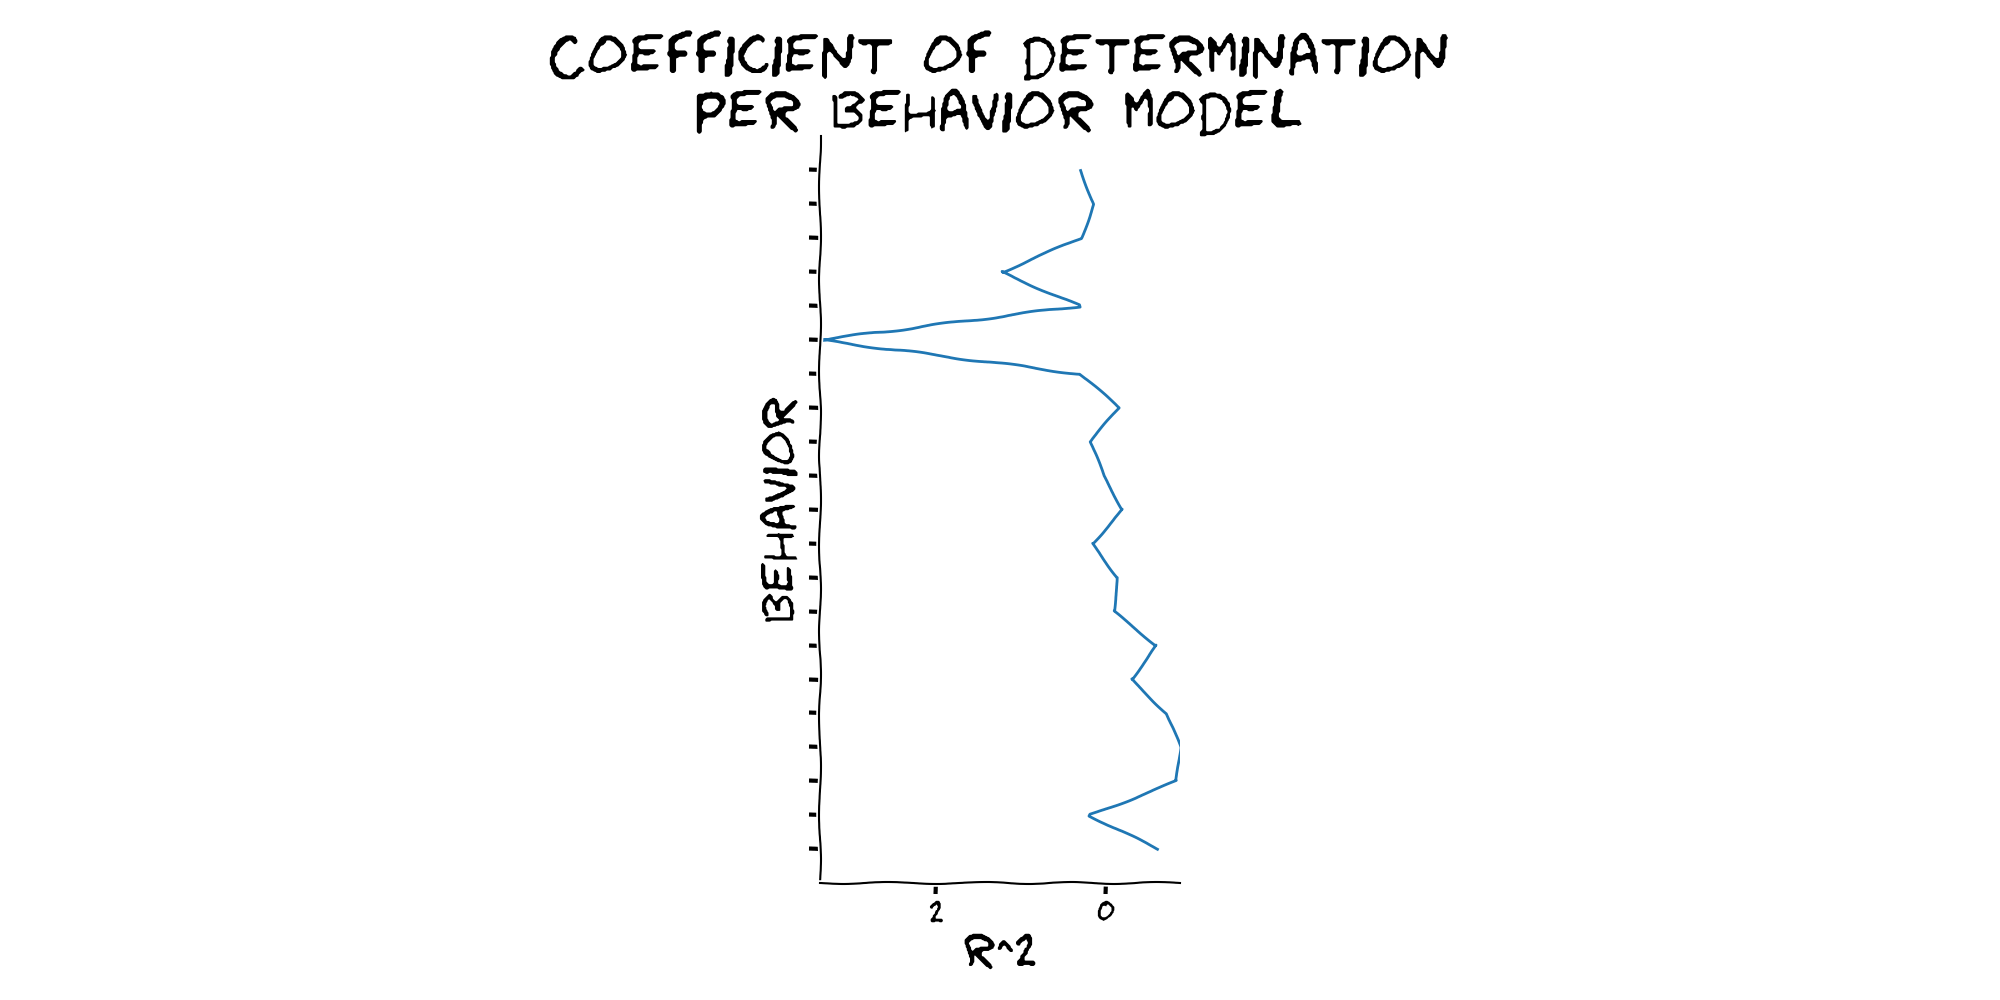

/usr/local/lib/python3.10/dist-packages/ipympl/backend_nbagg.py:279: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  self.manager.handle_json(content)


In [ ]:
with plt.xkcd():

  fig, ax = plt.subplots()
  ax.plot(r2, range(len(r2)))  # Swap x and y
  ax.set_xlabel('r^2')
  ax.set_ylabel('behavior')
  ax.set_yticks(np.arange(len(behavior_names[:21])))
  ax.set_yticklabels([])
  ax.set_xlim(min(r2), max(r2))  # Set limits to min/max of data
  ax.set_title('Coefficient of determination\nper behavior model')
  ax.set_aspect(aspect=0.4)  # Force aspect ratio of 2 (width) : 10 (height)
  # plt.show()
  fig.savefig('r_squared.png', transparent=True)



/usr/local/lib/python3.10/dist-packages/ipympl/backend_nbagg.py:336: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  self.figure.savefig(buf, format='png', dpi='figure')


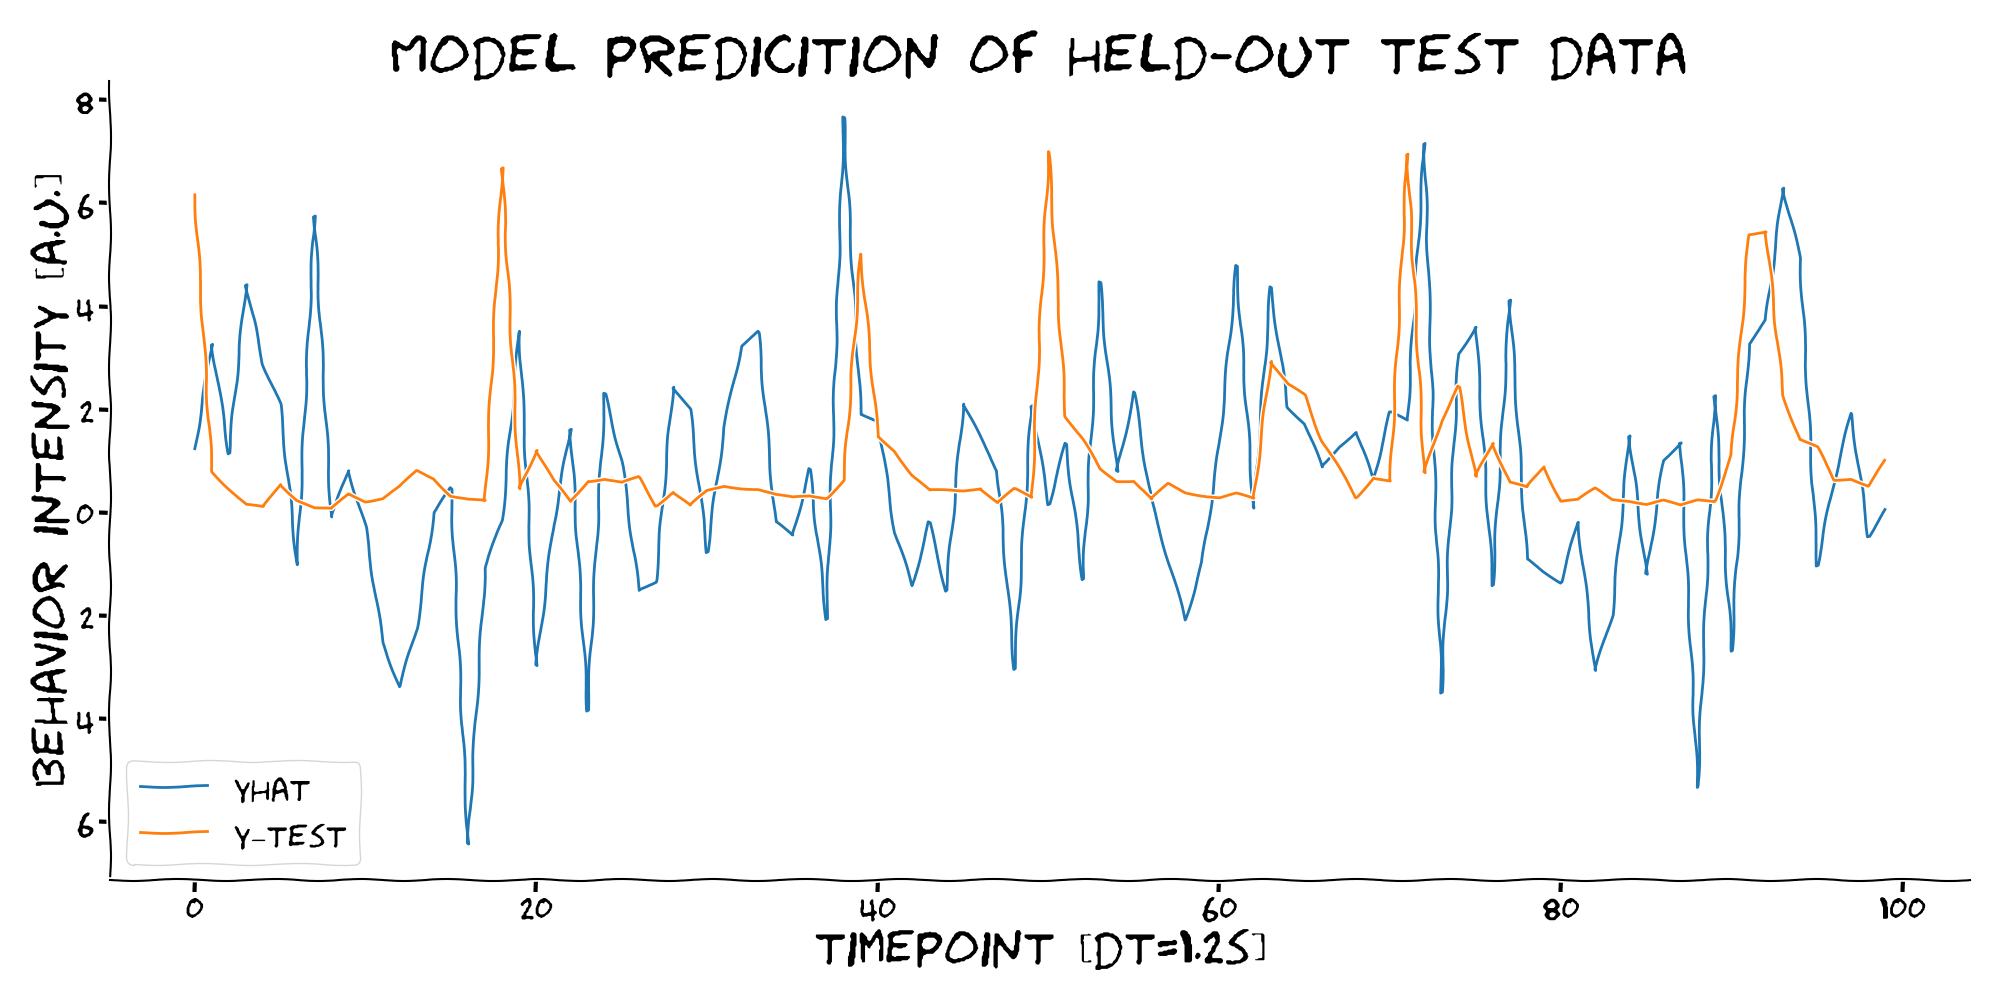

/usr/local/lib/python3.10/dist-packages/ipympl/backend_nbagg.py:279: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  self.manager.handle_json(content)


In [ ]:
%matplotlib widget
model = models['eye_position']
X = dat['sresp'].T
y = behaviors[1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=False)
# scaler = StandardScaler()
# y_test = scaler.fit_transform(y_test)
y_pred = model.predict(X_test)

with plt.xkcd():
  plt.figure(figsize=(20,10))
  plt.plot(y_pred[:100], label='yhat')
  plt.plot(y_test[:100], label='y_test')
  plt.xlabel("timepoint [dt=1.2s]")
  plt.ylabel("behavior intensity [a.u.]")
  plt.legend()
  plt.title('Model predicition of held-out test data')
  plt.savefig('full.png')

In [ ]:
# @title Visualize absolute weights for all neurons and the selected behaviors

import warnings
warnings.filterwarnings('ignore')

data = np.abs(absolute_weights.T)
with plt.xkcd():
  fig, ax = plt.subplots()


  cax = ax.imshow(data, aspect=data.shape[1]/data.shape[0],
            vmin=np.quantile(data, 0.1),
            vmax=np.quantile(data, 0.9),
            )

  ax.set_yticks(np.arange(len(behavior_names[:21])))
  ax.set_yticklabels(behavior_names[:21])
  # minor ticks between major ones
  ax.set_yticks(np.arange(len(behavior_names[:21])) + 0.5, minor=True)

  # Turn grid on for only minor ticks
  ax.grid(which='minor', color='w', linestyle='-', linewidth=1)

  fig.colorbar(cax)
  ax.set_xlabel('neuron #')
  ax.set_ylabel('behavior')
  plt.savefig('coefs.png')

Text(0, 0.5, 'behavior')

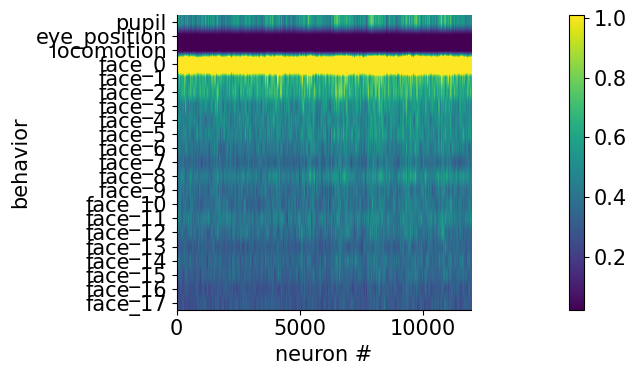

In [ ]:
# @title Visualize transformed weights for all neurons and the selected behaviors
data = np.abs(transformed_weights.T)
plt.figure()
plt.imshow(data, aspect=data.shape[1]/data.shape[0],
           vmin=np.quantile(data, 0.1),
           vmax=np.quantile(data, 0.9))
plt.colorbar()
plt.yticks(range(len(behavior_names[:21])), behavior_names[:21])
plt.xlabel('neuron #')
plt.ylabel('behavior')


In [ ]:
# @title This is implementing the same as above, but also using a circular shift permutation to obtain a distribution of alphas, maes and eweights,allowing to judge significance
import matplotlib
import joblib
from joblib import parallel, delayed
from matplotlib import gridspec
from matplotlib.backends.backend_pdf import PdfPages
from pandas.plotting import autocorrelation_plot
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import median_absolute_error
from sklearn.metrics import PredictionErrorDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
import scipy as sp


class EvaluateLinear():

  def __init__(self, model, X_train, y_train, X_test, y_test):
    self.mae_train = median_absolute_error(y_train, model.predict(X_train))
    self.y_pred = model.predict(X_test)
    self.y_test = y_test
    self.residuals = self.y_test - self.y_pred
    self.mae_test = median_absolute_error(self.y_test, self.y_pred)

  def plot_residuals_over_time(self, ax=None):
    ''''''

    if ax is None:
        _, ax = ax.subplots(figsize=(14, 8))
    ax.plot(self.residuals)
    ax.set_title("Residuals over Time")
    return ax

  def plot_histogram_of_residuals(self, ax=None):
    ''''''
    if ax is None:
        _, ax = ax.subplots(figsize=(8, 6))
    ax.hist(self.residuals, bins=30)
    ax.set_title("Histogram of Residuals")
    return ax

  def plot_autocorrelation_of_residuals(self, ax=None):
    ''''''
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 7))
    ax = autocorrelation_plot(self.residuals, ax=ax)
    ax.set_title("Autocorrelation of Residuals")
    return ax

  def plot_paired_pred_test(self, ax=None):
    ''''''

    scores = {
        "MedAE on training set": f"{self.mae_train:.2f}",
        "MedAE on testing set": f"{self.mae_test:.2f}",
    }
    if ax is None:
        _, ax = ax.subplots(figsize=(5, 5))
    display = PredictionErrorDisplay.from_predictions(
        self.y_test, self.y_pred, kind="actual_vs_predicted", ax=ax, scatter_kwargs={"alpha": 0.5}
    )
    ax.set_title("Ridge model, small regularization")
    for name, score in scores.items():
        ax.plot([], [], " ", label=f"{name}: {score}")
    ax.legend(loc="upper left")
    return ax

  def plot_predicted_vs_test(self, ax=None):
    ''''''
    if ax is None:

      _, ax = ax.subplots(figsize=(14, 8))
    ax.plot(self.y_pred[:100], label='yhat')
    ax.plot(self.y_test[:100], label='y_test')
    ax.legend()
    ax.set_title('Model predicition of held-out test data')
    return ax

  def compose_plots(self, export_path: str) -> None:
    '''
    Combine all plots into a single figure, put out a pdf.


    '''
    with PdfPages(export_path) as pp:
        fig = plt.figure(figsize=(11.69291*2, 8.267717*2)) # A4 values in inches *2, horizontal
        gs = gridspec.GridSpec(30, 18, left=0.05, right=.95, top=.92, bottom=.05, wspace=0.00, hspace=0.00)

        ax_pred = fig.add_subplot(gs[0:10, :])
        ax_restime = fig.add_subplot(gs[11:20, :])
        ax_paired  = fig.add_subplot(gs[21:27, :5])
        ax_hist = fig.add_subplot(gs[21:27, 6:11])
        ax_corr = fig.add_subplot(gs[21:27, 12:18])

        self.plot_predicted_vs_test(ax_pred)
        self.plot_residuals_over_time(ax_restime)
        self.plot_paired_pred_test(ax_paired)
        self.plot_histogram_of_residuals(ax_hist)
        self.plot_autocorrelation_of_residuals(ax_corr)

        # Save the current page to the PDF file
        pp.savefig()
        plt.close()

def find_optimal_alpha(X_train, y_train):
  preprocessor = make_column_transformer(
    (StandardScaler(), list(range(X_train.shape[1]))), # does the same as zscore + normalize to vector length
    verbose_feature_names_out=False,  # avoid to prepend the preprocessor names
  )
  alphas_iter_1 = np.logspace(-10, 1, 50)
  tscv = TimeSeriesSplit(n_splits=5)

  model = make_pipeline(
      preprocessor,
      RidgeCV(alphas=alphas_iter_1, cv=tscv),
  )

  model.fit(X_train, y_train)
  best_log_alpha = model.named_steps['ridgecv'].alpha_
  pow = int(np.log10(best_log_alpha))

  # Re-fit more precisely
  start = best_log_alpha - 10**pow
  stop = best_log_alpha + 10**pow
  alphas_iter_2 = np.linspace(start, stop)
  alphas_iter_2 = alphas_iter_2[alphas_iter_2 > 0]

  model = make_pipeline(
      preprocessor,
      RidgeCV(alphas=alphas_iter_2, cv=tscv),
  )

  model.fit(X_train, y_train)
  return model

def circular_shift_model(X: np.ndarray, y: np.ndarray, n_shifts: int = 10) -> np.ndarray:
    '''
    Estimate true weight distribution by circularly shifting the stimulus and fitting the model to each shift.

    Parameters

    '''
    # Initialize array to hold the weight distributions
    weight_distributions = np.zeros((X.shape[1], n_shifts))
    alphas = np.zeros(n_shifts)
    maes = np.zeros(n_shifts)
    y = y[1009:-1009]

    for i in range(n_shifts):

        # Only take the middle 5000 frames, to avoid edge effects
        shift = np.random.randint(0, X.shape[1]-5000)
        X_iter = np.roll(X, shift, axis=1)
        X_iter = X_iter[:, 1009:-1009]


        # Split the data into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(X_iter, y, test_size=0.5, shuffle=False)

        # Fit the model
        model = find_optimal_alpha(X_train, y_train)


        mae_train = median_absolute_error(y_train, model.predict(X_train))
        y_pred = model.predict(X_test)
        weight_distributions[:, i] = model.named_steps['ridgecv'].coef_
        alphas[i] = model.named_steps['ridgecv'].alpha_
        maes[i] = median_absolute_error(y_test, y_pred)

    return weight_distributions, alphas, maes


#Take only central part of the data
X = dat['sresp'].T[1009:-1009]
n_shifts = 1000

def process_behavior(behavior, name):
  y = behavior[1009:-1009]

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=False)
  model = find_optimal_alpha(X_train, y_train)

  weight_distributions, alphas, maes = circular_shift_model(X, y, n_shifts=n_shifts)# Save the 2D array to a .npy file
  filename = f"{name}_weights.npy"
  np.save(filename, weight_distributions)

  # create a list of column names
  alpha_cols = [f'alpha_{i}' for i in range(n_shifts)]
  mae_cols = [f'mae_{i}' for i in range(n_shifts)]

  # create separate columns for each alpha and mae
  data = {col: alpha for col, alpha in zip(alpha_cols, alphas)}
  data.update({col: mae for col, mae in zip(mae_cols, maes)})

  df = pd.DataFrame(data)

  # add the remaining columns
  df['weight_distributions'] = [filename]*X.shape[1]
  df['model_weights'] = model.named_steps['ridgecv'].coef_.tolist()
  df['model_alphas'] =  [model.named_steps['ridgecv'].alpha_]*X.shape[1]
  df['model_maes'] = [median_absolute_error(y_train, model.predict(X_train))]*X.shape[1]

  # Save the DataFrame to a .parquet file without compression
  df.to_parquet(f"/content/drive/My Drive/{name}_data.parquet", compression=None)

  joblib.dump(model, f"/content/drive/My Drive/{name}_model.pkl")

  evaluator = EvaluateLinear(model, X_train, y_train, X_test, y_test)
  evaluator.compose_plots(export_path=f"/content/drive/My Drive/{name}_evaluate.pdf")

Parallel(n_jobs=-1)(delayed(process_behavior)(behavior, name) for behavior, name in zip(behaviors[1:], behavior_names[1:]))


NameError: ignored